In [1]:
import scipy.stats as sps
import math
import numpy as np
from collections import defaultdict
from collections.abc import Callable, Iterable
from functools import lru_cache
from itertools import combinations
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

In [2]:
SAMPLE_SIZES = [10, 20, 50, 100, 200]
SIMPLE_METHODS = ["z-score", "modified z-score", "IQR"]
METHOD_PAIRS = list(combinations(SIMPLE_METHODS, 2))
METHODS = ["z-score", "modified z-score", "IQR", "at least 2"]
M = 10 ** 3
FRR = 0.05
N = 500
MODELLING_SIZE = 1000

In [3]:
DISTROS = {"Norm":    sps.norm(    loc=0,             scale=1),
           "Uniform": sps.uniform( loc=-math.sqrt(3), scale=2 * math.sqrt(3)),
           "Exp":     sps.expon(   loc=-1,            scale=1)}

Можно удостовериться, что все эти случайные величины действительно стандартные (с нулевым матожиданием и единичной дисперсией): 

In [4]:
for d in DISTROS:
    print(f"{d}: E[r] = {DISTROS[d].stats('m')}, Var[r] = {DISTROS[d].stats('v'):.1f}")

Norm: E[r] = 0.0, Var[r] = 1.0
Uniform: E[r] = 0.0, Var[r] = 1.0
Exp: E[r] = 0.0, Var[r] = 1.0


Реализуем определение выбросов обычным z_score. Для этого для каждого распределения нужно найти критическое его значение $z_{\text{крит}}$ методом моделирования

In [5]:
def z(sample: Iterable[float],
      el: float | Callable[[Iterable], float] | None = None
      ) -> float | list[float]:

        x_mean, s = np.mean(sample), np.std(sample)
        if el is not None:
            try:
                x = float(el)
            except:
                x = el(sample)
            return abs(x - x_mean) / s
        else:
            return [abs(x - x_mean) / s for x in sample]

In [6]:
@lru_cache
def get_z_crit(distribution: str, frr: float):
    # z_1_distr = [z(DISTROS[distribution].rvs(MODELLING_SIZE), min) for _ in range(N)]
    # z_critical = np.quantile(z_1_distr, 1 - frr)
    z_distr = [z(DISTROS[distribution].rvs(MODELLING_SIZE)) for _ in tqdm(range(N))]
    z_critical = np.quantile(z_distr, 1 - frr)
    return z_critical

def detect_outliers_z_score(sample, distribution, frr):
    z_critical = get_z_crit(distribution, frr)
    outliers = [x for x in sample if z(sample, x) > z_critical]
    return outliers

Для реализации критерия с модифицированным z_score, нужно найти отношение $\displaystyle \frac{\text{MAD}[r]}{\hat{\sigma}_r}$ для наших распределений, где $\hat{\sigma}_r$ - оценка стандартного отклонения распределения $r$.

Для нормального распределения $X \sim \mathcal{N}(a, \sigma^2)$ это
$$\text{MAD}[X] = \text{med}|X-\text{med}[X]| = \text{med}[|X-a|] = \text{med}[|Y|]$$
По определению медианы
$$\frac{1}{2} = \mathbb{P}(|X-a| < \text{med}[|X-a|]) = \mathbb{P}(|X-a| < \text{MAD}[X]) = \mathbb{P}\left(\frac{|X-a|}{\sigma} < \frac{\text{MAD}[X]}{\sigma}\right) = \mathbb{P}\left(|Y| < \frac{\text{MAD}[X]}{\sigma}\right) , \;\; Y \sim \mathcal{N}(0, 1)$$
$$\frac{1}{2} =  \Phi\left(\frac{\text{MAD}[X]}{\sigma}\right) - \Phi\left(-\frac{\text{MAD}[X]}{\sigma}\right) = \Phi\left(\frac{\text{MAD}[X]}{\sigma}\right) - \left(1- \Phi\left(\frac{\text{MAD}[X]}{\sigma}\right)\right)$$
$$\frac{3}{4} = \Phi\left(\frac{\text{MAD}[X]}{\sigma}\right)$$
$$\frac{\text{MAD}[X]}{\sigma} = \Phi^{-1}(0.75) \approx 0.6745$$

<!-- 
$$\mathbb{E}|Y| = \int_{-\infty}^{+\infty} \frac{|y|}{\sigma \sqrt{2\pi}} e^{-\frac{y^2}{2\sigma^2}}dy = \int_{-\infty}^0 \frac{-y}{\sigma \sqrt{2\pi}} e^{-\frac{y^2}{2\sigma^2}}dy + \int_{0}^{+\infty} \frac{y}{\sigma \sqrt{2\pi}} e^{-\frac{y^2}{2\sigma^2}}dy = $$
$$= 2 \int_{0}^{+\infty} \frac{y}{\sigma \sqrt{2\pi}} e^{-\frac{y^2}{2\sigma^2}}dy \underset{u = -\frac{y^2}{2\sigma^2}}{=} 2 \int_0^{+\infty} \frac{-\sigma}{\sqrt{2\pi}}e^{-u} du = \sigma \sqrt{\frac{2}{\pi}} \Rightarrow $$
$$\Rightarrow\frac{\text{MAD}[X]}{\sigma} = \sqrt{\frac{2}{\pi}} \approx 0.7979$$ -->

Для равномерного распределения $X \sim \text{Uniform}[a, b]$ это
$$\text{MAD}[X] = \text{med}|X-\text{med}[X]| = \text{med}|X-\mathbb{E}X| = \mathbb{E}|X-\mathbb{E}X| $$
в силу как симметричности распределения $\text{Uniform}[a,b]$, так и распределения $|\text{Uniform}[-c,c]|$. Итого
$$\text{MAD}[X] = \mathbb{E}\left|X - \frac{b+a}{2}\right| = \int_a^b \left|x - \frac{b+a}{2}\right|\cdot\frac{1}{b-a} dx =$$
$$= \int_a^{\frac{b+a}{2}} \left(\frac{b+a}{2} - x\right)\cdot\frac{1}{b-a} dx + \int_{\frac{b+a}{2}}^b \left(x - \frac{b+a}{2}\right)\cdot\frac{1}{b-a} dx = 2\int_{\frac{b+a}{2}}^b \left(x - \frac{b+a}{2}\right)\cdot\frac{1}{b-a} dx = \frac{b-a}{4} \Rightarrow$$
$$\Rightarrow \frac{\text{MAD}[X]}{\sigma} = \frac{\frac{b-a}{4}}{\frac{b-a}{\sqrt{12}}} = \frac{\sqrt{3}}{2} \approx 0.866$$

Для экспоненциального распределения $X \sim \text{Exp}(\lambda)$ найти $\text{MAD}$ уже гораздо сложнее. В силу его несимметричности медиана не равна математическому ожиданию, а значит, его придётся искать честно 
$$\text{MAD}[X] = \text{med}[|X-\text{med}[X]|] = \text{med}\left[\left|X - \frac{\ln2}{\lambda}\right|\right] = \text{med}[Y], \text{ где } Y \sim \left|X - \frac{\ln2}{\lambda}\right|$$
Тогда мы можем сказать, что функция распределения $Y$ имеет вид:
$$p_Y(t) =
\begin{cases}
0, & t \leqslant 0 \\
p_X\left(t + \frac{\ln2}{\lambda}\right) + p_X(t), &  0 < t \leqslant \frac{\ln2}{\lambda} \\
p_X\left(t + \frac{\ln2}{\lambda}\right), & \frac{\ln2}{\lambda} < t
\end{cases}
$$
Тогда чтобы найти медиану $Y$, достаточно решить уравнение
$$\int_{-\infty}^{M} p_Y(t) dt = \frac{1}{2}$$
относительно $M$, где $M=\text{MAD}[X]$. Хоть плотность и задана кусочно, мы знаем, что интеграл куска, который отразился в правую полуплоскость после модуля, равен $0.5$ (поскольку мы сдвинули влево исходную плотность ровно на медиану). Значит интеграл от $p_Y(t)$ по отрезку $[0; \frac{\ln2}{\lambda}]$ точно больше $0.5$, а значит искать $M$ имеет смысл только на нём. Итого:
$$\int_0^M p_X\left(t + \frac{\ln2}{\lambda}\right) + p_X(t) dt = \frac{1}{2}$$
$$\int_0^M \lambda e^{-\lambda t} + \lambda e^{-\lambda \left(t + \frac{\ln2}{\lambda}\right)} dt = \frac{1}{2}$$
$$\lambda \int_0^M e^{-\lambda t} + e^{-\lambda t - \ln2} dt = \frac{1}{2}$$
$$\lambda \left(1 + \frac{1}{e^{\ln2}}\right) \int_0^M e^{-\lambda t} dt = \frac{1}{2}$$
$$\frac{3\lambda}{2} \cdot \frac{1-e^{-\lambda M}}{\lambda} = \frac{1}{2}$$
$$3 \left(1-e^{-\lambda M}\right) = 1$$
$$M = \frac{\ln{\frac{3}{2}}}{\lambda}$$
Итого получили, что
$$\text{MAD}[X] = \frac{\ln{\frac{3}{2}}}{\lambda} \Rightarrow \frac{\text{MAD}[X]}{\sigma} = \frac{\frac{\ln{\frac{3}{2}}}{\lambda}}{\sqrt{\frac{1}{\lambda^2}}} = \ln\frac{3}{2} \approx 0.4055$$

In [ ]:
MAD_TO_STD = {"Norm": sps.norm.ppf(0.75),
              "Uniform": math.sqrt(3) / 2,
              "Exp": math.log(1.5)}

In [8]:
def modif_z(sample: Iterable[float],
            distribution: str,
            el: float | Callable[[Iterable], float] | None = None
            ) -> float | list[float]:
        x_med, mad = np.median(sample), sps.median_abs_deviation(sample)
        if el is not None:
            try:
                x = float(el)
            except:
                x = el(sample)
            return (abs(x - x_med) / mad) * MAD_TO_STD[distribution]
        else:
            return [(abs(x - x_med) / mad) * MAD_TO_STD[distribution] for x in sample]

@lru_cache
def get_modified_z_crit(distribution, frr):
    # z_1_distr = [modif_z(DISTROS[distribution].rvs(MODELLING_SIZE), distribution, min) for _ in range(N)]        
    # z_critical = np.quantile(z_1_distr, 1 - frr)
    z_distr = [modif_z(DISTROS[distribution].rvs(MODELLING_SIZE), distribution) for _ in tqdm(range(N))]
    z_critical = np.quantile(z_distr, 1 - frr)
    return z_critical

def detect_outliers_modified_z_score(sample, distribution, frr):
    z_critical = get_z_crit(distribution, frr)
    outliers = [x for x in sample if modif_z(sample, distribution, x) > z_critical]
    return outliers

Чтобы найти границы значений, которых мы не считаем выбросами в IQR, нужно найти некоторую константу $k$ (вместо традиционной универсальной $k=1.5$). Для симметричных распределений Norm и Uniform мы хотим, чтобы 
$$\mathbb{P}(x > x_{0.75} + k_{\text{sym}} \cdot \text{IQR}) = \frac{\alpha}{2}$$
$$1 - \mathbb{P}(x < x_{0.75} + k_{\text{sym}} \cdot \text{IQR}) = \frac{\alpha}{2}$$
$$\mathbb{P}(x < x_{0.75} + k_{\text{sym}} \cdot \text{IQR}) = 1-\frac{\alpha}{2}$$
$$x_{0.75} + k_{\text{sym}} \cdot \text{IQR} = x_{1-\frac{\alpha}{2}}$$
$$k_{\text{sym}} = \frac{x_{1-\frac{\alpha}{2}} - x_{0.75}}{\text{IQR}}$$
Однако такое не сработает с экспоненциальным распределением. Предлагаю для него использовать несколько иной критерий, то есть считать выбросами всё, что больше $x_{0.75} + k_{\text{Exp}}\cdot \text{IQR}$. Тогда все вычисления выше подходят и здесь, но вместо $\frac{\alpha}{2}$ будет просто $\alpha$, и тогда
$$k_{\text{Exp}} = \frac{x_{1-\alpha} - x_{0.75}}{\text{IQR}}$$

In [9]:
@lru_cache
def quant(distribution: str, q: float) -> float:
    return DISTROS[distribution].ppf(q)

@lru_cache
def IQR_k(distribution, frr):
    match distribution:
        case 'Norm':
            return (quant(distribution, 1 - frr / 2) - quant(distribution, 0.75)) /  (quant(distribution, 0.75) - quant(distribution, 0.25))
        case 'Uniform':
            return (quant(distribution, 1 - frr / 2) - quant(distribution, 0.75)) /  (quant(distribution, 0.75) - quant(distribution, 0.25))
        case 'Exp':
            return (quant(distribution, 1 - frr) - quant(distribution, 0.75)) /  (quant(distribution, 0.75) - quant(distribution, 0.25))
        case _:
            return 1.5

def detect_outliers_IQR(sample, distribution, frr):
    x_25, x_75 = quant(distribution, 0.25), quant(distribution, 0.75)
    IQR = x_75 - x_25
    k = IQR_k(distribution, frr)
    left = x_25 - k * IQR
    right = x_75 + k * IQR
    outliers = [x for x in sample if not left <= x <= right]
    return outliers

Найти $k$ можно и оценочно, оценив каждую квантиль через выборочные квантили.

In [10]:
def estimate_k(distribution, frr):
    samples = [DISTROS[distribution].rvs(N) for _ in range(MODELLING_SIZE)]
    q = 1 - frr if distribution == 'Exp' else 1 - (frr / 2)
    quantiles = [[np.quantile(x, 0.25), np.quantile(x, 0.75), np.quantile(x, q)] for x in samples]
    x_25, x_75, x_alpha = np.mean(quantiles, axis=0)
    k_est = (x_alpha - x_75) / (x_75 - x_25)
    return k_est

In [11]:
estimate_k('Exp', FRR), IQR_k('Exp', FRR)

(1.4451080597616106, 1.4649735207179264)

Обёрточная функция над всеми методами для удобства. Метод 'at least 2' подразумевает использование всех трёх методов, при этом выбросами признаются те значения, которые были определены как выбросы хотя бы двумя методами.

In [12]:
def detect_outliers(sample: Iterable, distribution: str, frr: float, method: str) -> list[float]:
    match method:
        case 'z-score':
            return detect_outliers_z_score(sample, distribution, frr)
        case 'modified z-score':
            return detect_outliers_modified_z_score(sample, distribution, frr)
        case 'IQR':
            return detect_outliers_IQR(sample, distribution, frr)
        case 'at least 2':
            outliers = {method: set(detect_outliers(sample, distribution, frr, method)) for method in SIMPLE_METHODS}
            res = set()
            for (method_1, method_2) in METHOD_PAIRS:
                res |= outliers[method_1] & outliers[method_2]
            return list(res)
        case _:
            return []

In [13]:
# method, distribution, n
results = {method: {distr: {} for distr in DISTROS} for method in METHODS}
for n_id, n in enumerate(SAMPLE_SIZES):
    print("Sample size", n)
    for distr_id, distr in enumerate(DISTROS):
        print("   ", distr)
        cur_res = defaultdict(int)
        for _ in trange(M):
            sample = DISTROS[distr].rvs(n)
            for method in METHODS:
                cur_res[method] += len(detect_outliers(sample, distr, FRR, method))
        for method in METHODS:
            results[method][distr][n] = cur_res[method] / (M * n)
    print('-' * 100)

Sample size 10
    Norm


100%|██████████| 1000/1000 [00:02<00:00, 458.52it/s]


    Uniform


100%|██████████| 1000/1000 [00:02<00:00, 457.75it/s]


    Exp


100%|██████████| 1000/1000 [00:02<00:00, 458.29it/s]


----------------------------------------------------------------------------------------------------
Sample size 20
    Norm


100%|██████████| 1000/1000 [00:03<00:00, 254.89it/s]


    Uniform


100%|██████████| 1000/1000 [00:03<00:00, 252.06it/s]


    Exp


100%|██████████| 1000/1000 [00:04<00:00, 249.40it/s]


----------------------------------------------------------------------------------------------------
Sample size 50
    Norm


100%|██████████| 1000/1000 [00:09<00:00, 105.56it/s]


    Uniform


100%|██████████| 1000/1000 [00:09<00:00, 105.41it/s]


    Exp


100%|██████████| 1000/1000 [00:09<00:00, 101.50it/s]


----------------------------------------------------------------------------------------------------
Sample size 100
    Norm


100%|██████████| 1000/1000 [00:19<00:00, 52.32it/s]


    Uniform


100%|██████████| 1000/1000 [00:19<00:00, 50.13it/s]


    Exp


100%|██████████| 1000/1000 [00:19<00:00, 50.50it/s]


----------------------------------------------------------------------------------------------------
Sample size 200
    Norm


100%|██████████| 1000/1000 [00:39<00:00, 25.29it/s]


    Uniform


100%|██████████| 1000/1000 [00:39<00:00, 25.63it/s]


    Exp


100%|██████████| 1000/1000 [00:39<00:00, 25.55it/s]

----------------------------------------------------------------------------------------------------


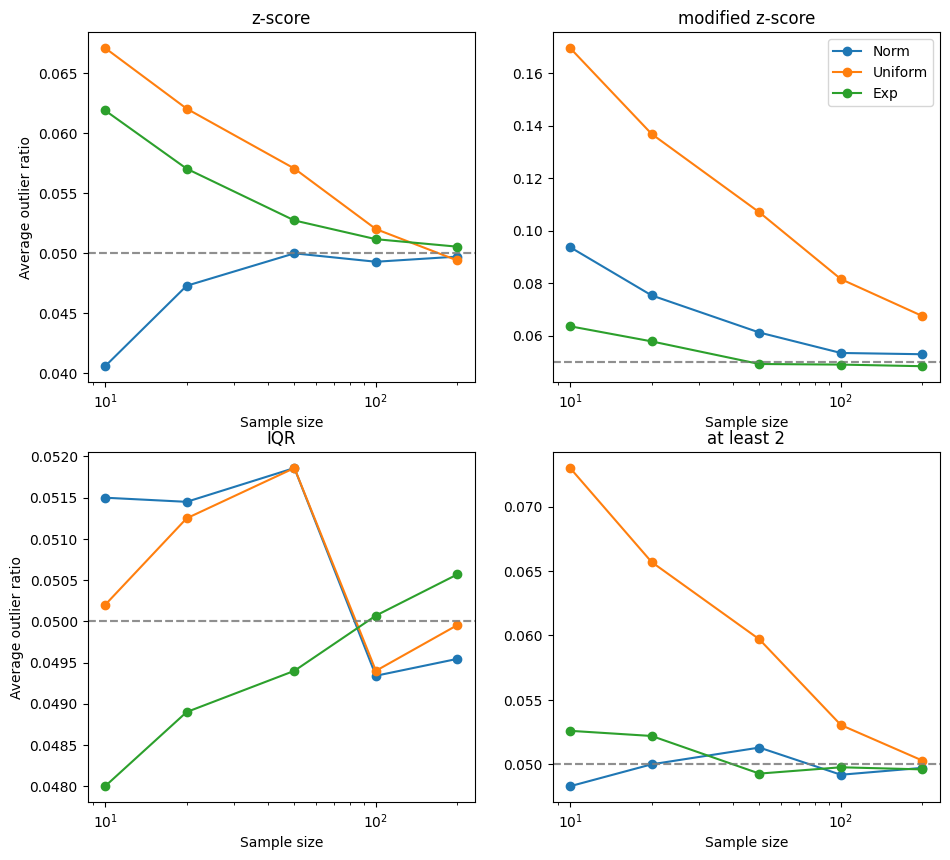

In [15]:
axis: list[list[plt.Axes]] = plt.subplots(2, 2, figsize=(11, 10))[1]

for method_id, method in enumerate(METHODS):
    ax = axis[method_id // 2][method_id % 2]
    ax.title.set_text(method)
    for distr_id, distr in enumerate(DISTROS):
        ax.plot(SAMPLE_SIZES, results[method][distr].values(), '-o', color='C'+str(distr_id), label=distr)
        ax.axhline(y=FRR, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel('Sample size')
        ax.set_xscale('log')
        # ax.set_ylim(FRR - 0.02, FRR + 0.02)
axis[0][1].legend()
axis[0][0].set_ylabel('Average outlier ratio')
axis[1][0].set_ylabel('Average outlier ratio')
plt.show()